In [76]:
import pandas as pd
import requests
import sys
import numpy as np
from io import StringIO
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

#download the raw data from wikipedia
r = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")

#transform the table into a dataframe
df = pd.read_html(r.text, header=0)[0]

In [28]:
# drops rows with borough not assigned
indexNames = df[ df['Borough'] == 'Not assigned' ].index
df.drop(indexNames , inplace=True)

In [29]:
# when neighbouthood is not assigned, copies values from borough
df.loc[(df.Neighbourhood == 'Not assigned'),'Neighbourhood']=df.Borough

In [30]:
#grouping neighborouhoods with the same postcode/borough together and separating them with a ,
grouped_df = df.groupby(['Postcode','Borough'])['Neighbourhood'].apply(lambda tags: ','.join(tags)).reset_index()

In [31]:
#retrieving GPS coordinates from CSV file
coordinates = pd.read_csv("Geospatial_Coordinates.csv")

In [33]:
#rename column to match existing Dataframe naming
coordinates=coordinates.rename(columns={"Postal Code": "Postcode"})

In [34]:
#merging gps coordinates with the existing dataframe
final_dataframe = pd.merge(grouped_df, coordinates, how='inner', on = 'Postcode')

In [114]:
#clustering neighbourhoods

from sklearn.cluster import KMeans

# set number of clusters
kclusters = 3

k_means = KMeans(init="k-means++", n_clusters=kclusters, n_init=12)
k_means.fit(final_dataframe[['Latitude','Longitude']])
labels = k_means.labels_


In [116]:
#storing cluster labels in the dataframe
final_dataframe["Labels"] = labels

In [117]:
#generating map

import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

map_clusters = folium.Map(location=[43.736542, -79.382826], zoom_start=11)


In [118]:
# create map - 3 main clusters

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(final_dataframe['Latitude'], final_dataframe['Longitude'], final_dataframe['Borough'], final_dataframe['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], radius=5, popup=label, color=rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.7).add_to(map_clusters)

map_clusters


In [88]:
#calculating optimal number of clusters
Sum_of_squared_distances = []
K = range(1,25)
for k in K:
    k_means = KMeans(init="k-means++", n_clusters=kclusters, n_init=100)
    km=k_means.fit(final_dataframe[['Latitude','Longitude']])
    Sum_of_squared_distances.append(km.inertia_)
    

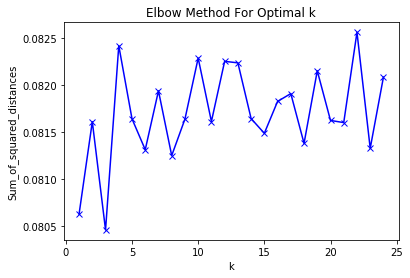

In [89]:
#3 seems to be the optimal number of clusters for this case. 

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()